# Purpose
Inspect the performance of each RR candidate seperately using Boxenplots, which is a combination of histograms and box plots.

Comparing the distributions of the merged candidates can help us determine which merging method yields the best results.

Comparing the distributions of each RIV candidate can help us determine which RIV candidate should be included during production. Are there RIV candidates that consistently perform well? Are there RIV candidates that consistently perform poorly?


In [1]:
from ppg2rr.rr_est import estimate_rr_dataset
from ppg2rr.evaluate import bland_altman, violin_comparison, scatter_compare
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings

In [2]:
# Define a context manager to ignore warnings
class IgnoreWarnings:
    def __enter__(self):
        warnings.filterwarnings("ignore")
        return self

    def __exit__(self, exc_type, exc_value, traceback):
        warnings.filterwarnings("default")

In [3]:
%load_ext autoreload
%autoreload 2

# only display 2 decimals
pd.set_option('display.precision', 2)
sns.set_style("darkgrid")

In [4]:
filename = 'kapiolani_peak count update - dynamic window size20231219 224729_features.csv'
# filename = 'kapiolani_kalman - skip derivatives if rqi gt 0.320231211 175257_features.csv'
df = pd.read_csv(f"../data/results/{filename}")

In [5]:
target = 'RR ref co2'
# target = 'RR ref (median)'

riv_list = [
    'AUDP',
    'RIAV_ascending',
    'RIAV_descending',
    'RIFV_mas','RIFV_max',
    'RIFV_min','RIIV_lower',
    'RIIV_upper',
    'STT',
    'ppg'
    ]

candidate_prefix_1 = 'candidate - # riv peaks-'
candidate_prefix_2 = 'candidate - riv peak median delta-'
candidate_prefix_3 = 'candidate - psd-'
candidate_prefix_4 = 'candidate - harmonic analysis-'

quality_prefix_1 = 'quality - RIV kurtosis-'
quality_prefix_2 = 'quality - RIV peak-diff std-'
quality_prefix_3 = 'quality - RIV skew-'
quality_prefix_4 = 'quality - psd RQI-'

merged_candidates = [
    'Counting, median # peaks',
    "Counting, median pk delta rqi cutoff",
    "Counting, median pk delta std cutoff",
    "kalman",
    "PSD median",
    "PSD, closest to prev RR",
    "mean of fused candidates",
    "median of fused candidates",
    "mode of fused candidates",
    "simple median",
    "buffered_display"
]

# Define subset of data to analyze

In [6]:
# poor_quality_frames will be excluded in the analyses below
poor_quality_frames = (
    ( df['quality - template matching-pct diagnostic quality pulses'] < 0.5)
    | df['aliased']
    | (df['co2 mean iqr'] < 0.15)
)

# Boxen Plots by RIV candidates

In [7]:
df[merged_candidates][~poor_quality_frames].sub(df[target],axis=0).describe()

,"Counting, median # peaks","Counting, median pk delta rqi cutoff","Counting, median pk delta std cutoff",kalman,PSD median,"PSD, closest to prev RR",mean of fused candidates,median of fused candidates,mode of fused candidates,simple median,buffered_display
count,1696.00,1696.00,1698.00,1698.00,1698.00,1698.00,1698.00,1698.00,1698.00,1698.00,1698.00
mean,-1.25,1.56,0.63,-1.64,-3.86,-2.00,-1.72,-1.86,-2.03,-1.49,-1.74
std,6.66,6.20,6.13,7.18,7.80,6.16,5.97,6.14,6.56,5.68,5.85
min,-47.68,-40.00,-40.00,-63.93,-63.43,-59.21,-55.39,-58.83,-57.10,-54.44,-55.39
25%,-4.27,-1.32,-2.03,-4.28,-7.06,-4.50,-3.92,-4.04,-4.64,-3.72,-3.88
50%,-0.32,1.09,0.49,-0.78,-1.98,-0.96,-0.71,-0.87,-1.39,-0.56,-0.73
75%,2.56,4.59,3.44,1.38,0.34,0.95,1.08,0.94,1.38,1.33,1.00
max,20.47,28.17,28.17,29.09,24.81,20.12,18.83,21.99,24.87,18.37,17.22


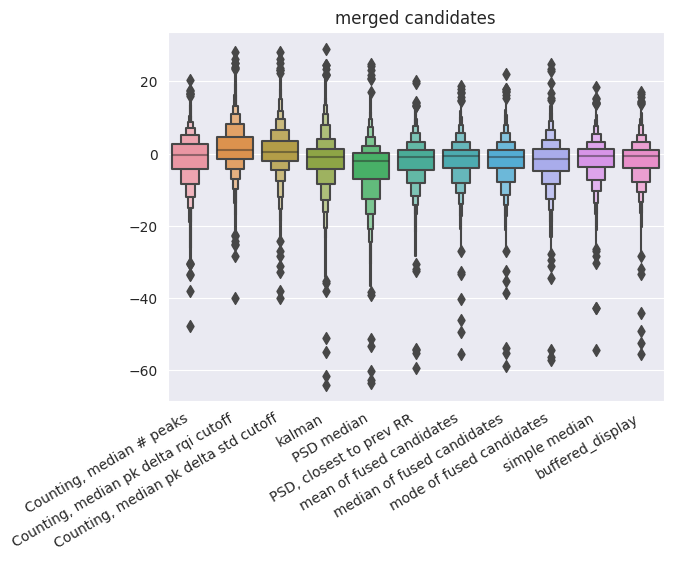

In [8]:
with IgnoreWarnings():
    sns.boxenplot(df[merged_candidates][~poor_quality_frames].sub(df[target],axis=0))
    plt.title("merged candidates")
    plt.xticks(rotation=30, ha='right')
    plt.show()

20424


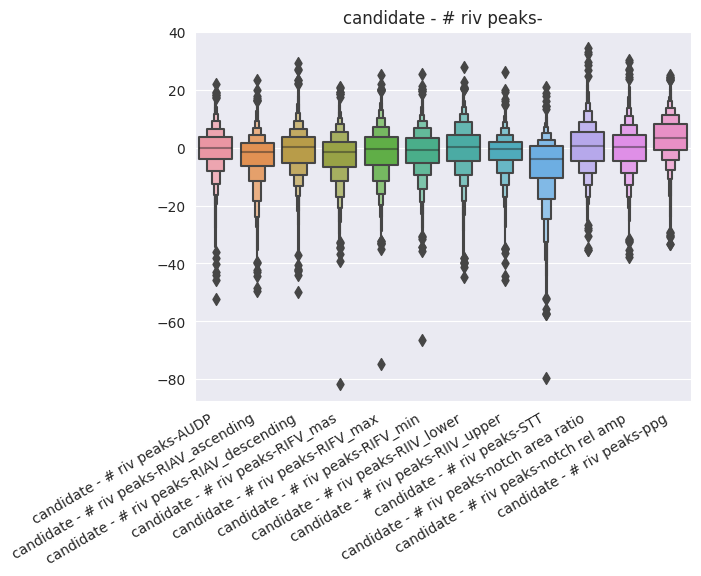

20424


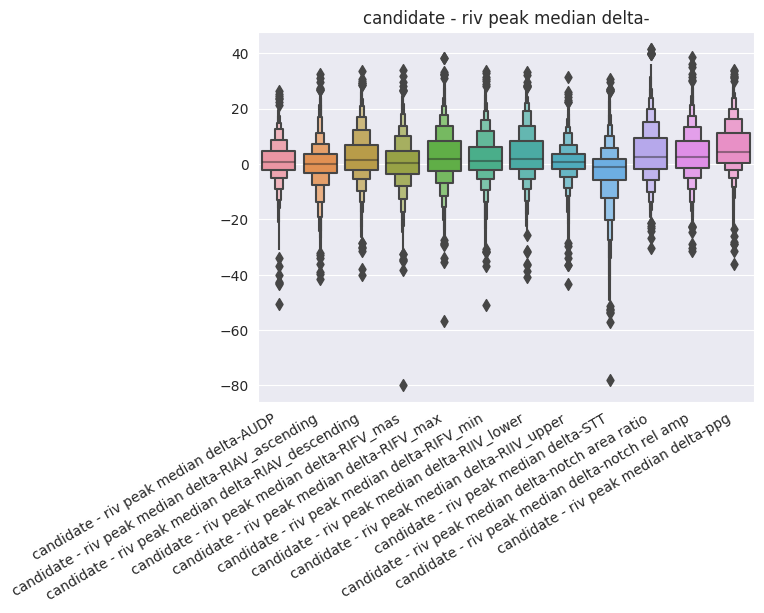

22126


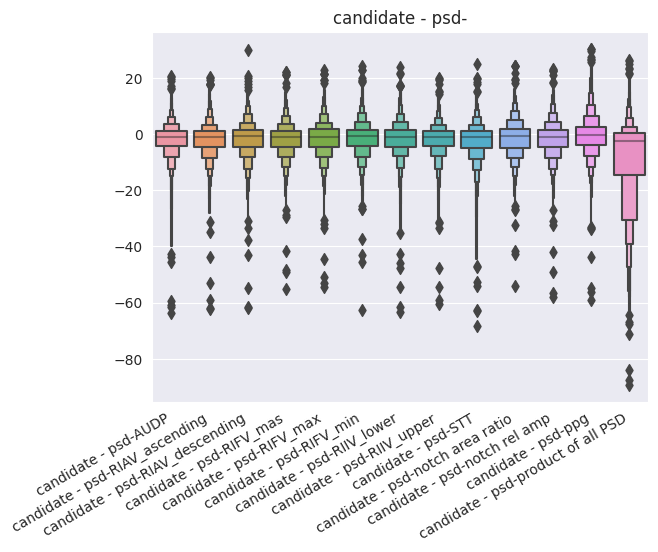

22126


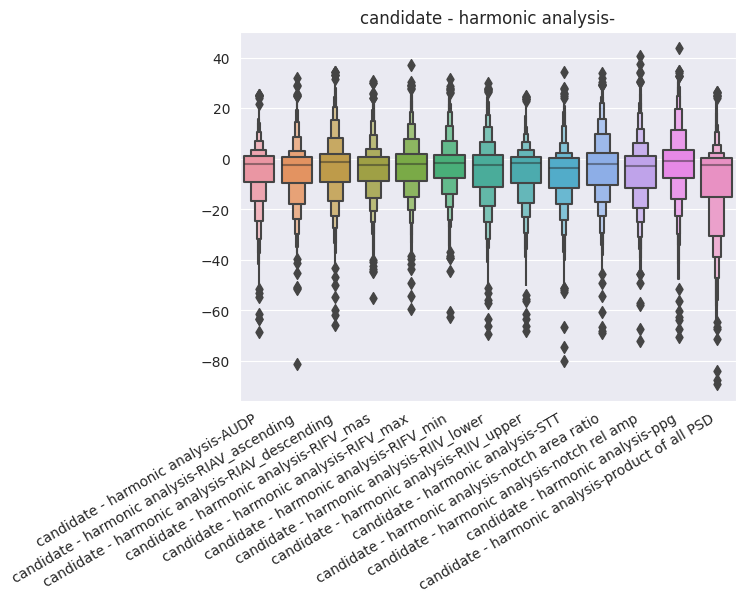

In [9]:
with IgnoreWarnings():
    candidates = [eval(f"candidate_prefix_{i}") for i in [1,2,3,4]]
    for candidate in candidates:
        df_filtered = df.filter(like=candidate)[~poor_quality_frames]
        print(df_filtered.size)
        sns.boxenplot(df_filtered.sub(df[target],axis=0))
        plt.title(candidate)
        plt.xticks(rotation=30, ha='right')
        plt.show()

# Boxplots by Subject

In [ ]:
df['PSD median']

In [16]:
young = df['subject age'] <= 5
px.box(
    y=(df['mode of fused candidates']-df['RR ref co2'])[young],
    x=df['trial'][young],
    )

In [40]:
px.box(
    y=df['buffered_display']-df['RR ref co2'],
    x=df['trial']
    )

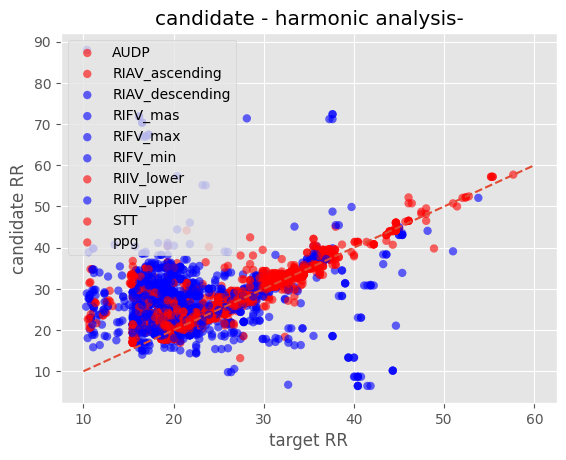

In [21]:
color = df['quality - template matching-pct diagnostic quality pulses'].apply(lambda x: 'blue' if x < 0.7 else 'red')
plt.style.use('ggplot')
for idx, riv in enumerate(riv_list):
    # error as a percentage
    high_q = df[f'{quality_prefix_4}{riv}'] > 0.3
    plt.scatter(x=df[high_q][f'{candidate_prefix_4}{riv}'], 
                y=df[high_q][target], 
                label=riv, 
                alpha=0.6, 
                edgecolors='none', 
                color=color[high_q],
                # color=colormap(idx)
                )
plt.plot([10, 60],[10, 60],'--')
plt.ylabel('candidate RR')
plt.xlabel('target RR')
plt.title(candidate_prefix_4)
plt.legend()
plt.show()


# Compare distributions of two sets of results

In [35]:
file1 = 'kapiolani_seed with display, add mode in final candidate fusion20231210 233344_features.csv'
file2 = 'kapiolani_kalman - skip derivatives if rqi gt 0.320231211 130200_features.csv'

df1 = pd.read_csv(f"../data/results/{file1}")
df2 = pd.read_csv(f"../data/results/{file2}")

In [39]:
good_qual = df1['quality - template matching-pct diagnostic quality pulses'] > 0.6
temp1 = (df1['kalman']-df1['RR ref co2'])[good_qual]
temp2 = (df2['kalman']-df2['RR ref co2'])[good_qual]

pd.DataFrame([temp1, temp2]).T.describe()

,0,1
count,1596.00,1596.00
mean,-0.40,-0.65
std,6.56,6.79
min,-43.93,-43.93
25%,-3.14,-3.53
50%,-0.44,-0.55
75%,1.97,1.78
max,32.19,32.19


In [38]:
violin_comparison(
    y1 = temp1,
    y2 = temp2,
    y1_label='swap rr_seed to buffered_display',
    y2_label='if gt 0.3 skip derivatives'
)
